* [5.5. APPENDIX: R CODE FOR FIGURES 5.1, 5.2, etc](#5.5.-APPENDIX:-R-CODE-FOR-FIGURES-5.1,-5.2,-etc)
* [Exercise 5.1](#Exercise-5.1)
* [Exercise 5.2](#Exercise-5.2)
* [Exercise 5.3](#Exercise-5.3)
* [Exercise 5.4](#Exercise-5.4)

## 5.5. APPENDIX: R CODE FOR FIGURES 5.1, 5.2, etc

python version of `BernGrid.R`

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from dbda2e_utils import HDIofGrid

In [2]:
def BernGrid(Theta, pTheta, Data, HDImass=0.95):
    # Create summary values of Data
    z = sum(Data) # number of 1's in Data
    N = len(Data)
    
    # Compute the Bernoulli likelihood at each value of Theta:
    pDataGivenTheta = Theta**z * (1-Theta)**(N-z)
    
    # Compute the evidence and the posterior via Bayes' rule:
    pData = sum(pDataGivenTheta * pTheta)
    pThetaGivenData = pDataGivenTheta * pTheta / pData
    
    assert np.allclose(sum(pTheta), 1)
    assert np.allclose(sum(pThetaGivenData), 1)
    
    f, axs = plt.subplots(3,1,figsize=(10,15))

    def annotate(Theta, Prob, ax, hdi=True):
        mode_text = 'mode = %.2f' % Theta[np.argmax(Prob)]
        ax.annotate(mode_text, xy=(0.85, 0.9), xycoords='axes fraction', fontsize=12)
        
        if not hdi:
            return

        # draw HDI
        HDIinfo = HDIofGrid(Prob , credMass=HDImass)
        hdi_x = Theta[HDIinfo['indices']]
        hdi_y = np.full_like(hdi_x, HDIinfo['height'])
        ax.plot(hdi_x, hdi_y, marker='.', color='k', ls='')
    
        ax.annotate(hdi_x[0], xy=(hdi_x[0], hdi_y[0]*1.1),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=12)
        ax.annotate(hdi_x[-1], xy=(hdi_x[-1], hdi_y[-1]*1.1),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    
        hdi_text = '%.0f%% HDI' % (HDImass * 100)
        hdi_mid_idx = len(hdi_x) // 2 
        ax.annotate(hdi_text, xy=(hdi_x[hdi_mid_idx], 1.3*hdi_y[hdi_mid_idx]),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=12)
        
    # Plot the prior
    axs[0].vlines(Theta, 0, pTheta, color='cornflowerblue', linewidth=2)
    axs[0].set_title('Prior')
    axs[0].set_xlabel(r'$\theta$')
    axs[0].set_ylabel(r'$p(\theta$)')
    annotate(Theta, pTheta, axs[0])
    
    # Plot the likelihood: p(Data|Theta)
    axs[1].vlines(Theta, 0, pDataGivenTheta, color='cornflowerblue', linewidth=2)
    axs[1].set_title('Likelihood')
    axs[1].set_xlabel(r'$\theta$')
    axs[1].set_ylabel(r'$p(D|\theta$)')
    data_text = 'Data: z = %d, N = %d' % (z, N)
    axs[1].annotate(data_text, xy=(0.02, 0.9), xycoords='axes fraction', fontsize=12)    
    annotate(Theta, pDataGivenTheta, axs[1], hdi=False)

    # Plot the posterior: p(Theta|Data)
    axs[2].vlines(Theta, 0, pThetaGivenData, color='cornflowerblue', linewidth=2)
    axs[2].set_title('Posterior')
    axs[2].set_xlabel(r'$\theta$')
    axs[2].set_ylabel(r'$p(\theta|D$)')
    annotate(Theta, pThetaGivenData, axs[2])

    plt.show()
    
    return pDataGivenTheta

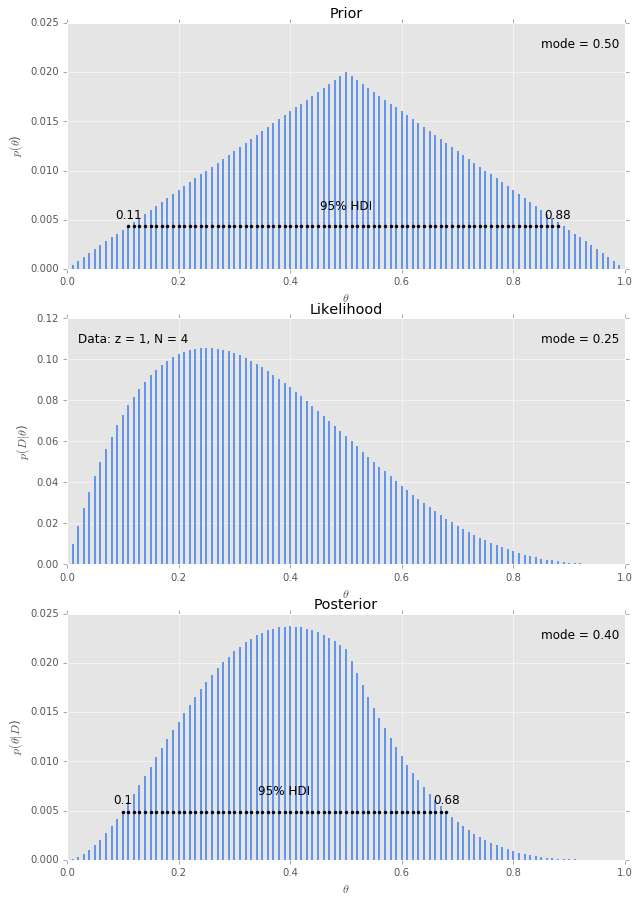

In [3]:
Theta = np.linspace(0, 1, num=101) # Specify fine comb for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for prior Theta, pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,3), np.repeat(1,1))) # Same as c(0,0,0,1). 25% heads with N=4.

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

## Exercise 5.1

**Purpose**: Iterative application of Bayes’ rule, and seeing how posterior probabilities change with inclusion of more data.

In [4]:
p_disease = 0.001
p_positive_given_disease = 0.99
p_positive_given_no_disease = 0.05

# p_disease_given_positive - ?
p_positive = p_positive_given_disease * p_disease + p_positive_given_no_disease * (1 - p_disease)
p_disease_given_positive = p_positive_given_disease * p_disease / p_positive
p_disease_given_positive

0.019434628975265017

In [5]:
p_disease2 = p_disease_given_positive
p_negative2 = (1-p_positive_given_disease) * p_disease2 + (1-p_positive_given_no_disease) * (1-p_disease2)
p_disease_given_negative2 = (1-p_positive_given_disease) * p_disease2 / p_negative2
p_disease_given_negative2

0.00020858616504854387

## Exercise 5.2

**Purpose**: Getting an intuition for the previous results by using “natural frequency” and “Markov” representations

In [6]:
import pandas as pd

### Part A

In [7]:
n_people = 100e3

In [8]:
# joint probability p(disease, test)
p_disease_test = [
    [p_positive_given_disease*p_disease,      p_positive_given_no_disease*(1-p_disease)],
    [(1-p_positive_given_disease)*p_disease,  (1-p_positive_given_no_disease)*(1-p_disease)]
]

p_disease_test = np.array(p_disease_test)
assert np.isclose(p_disease_test.sum(), 1.0)

In [9]:
freq_disease_test = p_disease_test * n_people
freq_disease_test = freq_disease_test.round().astype(int)
assert np.isclose(freq_disease_test.sum(), n_people)

In [10]:
freq_disease_test_df = pd.DataFrame(freq_disease_test, index=['D = +','D = -'], columns=['𝝷 = :(', '𝝷 = :)'])
freq_disease_test_df

,𝝷 = :(,𝝷 = :)
D = +,99,4995
D = -,1,94905


In [11]:
freq_disease = freq_disease_test.sum(axis=0)
freq_disease_df = pd.DataFrame([freq_disease], index=['disease freq'], columns=['𝝷 = :(', '𝝷 = :)'])
freq_disease_df

,𝝷 = :(,𝝷 = :)
disease freq,100,99900


In [12]:
freq_test = freq_disease_test.sum(axis=1)
freq_test_df = pd.DataFrame(freq_test, index=['D = +','D = -'], columns=['test freq'])
freq_test_df

,test freq
D = +,5094
D = -,94906


### Part B

In [13]:
p_disease_given_positive = freq_disease_test_df.loc['D = +'] / freq_test_df['test freq'].loc['D = +']
p_disease_given_positive

𝝷 = :(    0.019435
𝝷 = :)    0.980565
Name: D = +, dtype: float64

In [14]:
p_disease_given_positive['𝝷 = :(']

0.019434628975265017

### Part C

In [15]:
n_people = 10e6

compute the left branch

In [16]:
freq_disease = n_people * p_disease
freq_disease

10000.0

In [17]:
freq_positive_given_disease = freq_disease * p_positive_given_disease
freq_positive_given_disease

9900.0

In [18]:
freq_negative2_given_disease = freq_positive_given_disease * (1-p_positive_given_disease)
freq_negative2_given_disease

99.00000000000009

compute the right branch

In [19]:
freq_no_disease = n_people * (1-p_disease)
freq_no_disease

9990000.0

In [20]:
freq_positive_given_no_disease = freq_no_disease * p_positive_given_no_disease
freq_positive_given_no_disease

499500.0

In [21]:
freq_negative2_given_no_disease = freq_positive_given_no_disease * (1-p_positive_given_no_disease)
freq_negative2_given_no_disease

474525.0

### Part D

In [22]:
p_disease_given_negative2 = freq_negative2_given_disease / \
    (freq_negative2_given_disease + freq_negative2_given_no_disease)
p_disease_given_negative2

0.00020858616504854387

## Exercise 5.3

**Purpose**: To see a hands-on example of data-order invariance.

### Part A

In [23]:
# p_disease_given_negative - ?
p_negative = (1-p_positive_given_disease) * p_disease + (1-p_positive_given_no_disease) * (1-p_disease)
p_disease_given_negative = (1-p_positive_given_disease) * p_disease / p_negative
p_disease_given_negative

1.0536741618022054e-05

### Part B

In [24]:
# p_disease_given_positive2 - ?
p_disease2 = p_disease_given_negative
p_positive2 = p_positive_given_disease * p_disease2 + p_positive_given_no_disease * (1-p_disease2)
p_disease_given_positive2 = p_positive_given_disease * p_disease2 / p_positive2
p_disease_given_positive2

0.0002085861650485439

## Exercise 5.4

**Purpose**: To gain intuition about Bayesian updating by using `BernGrid`.

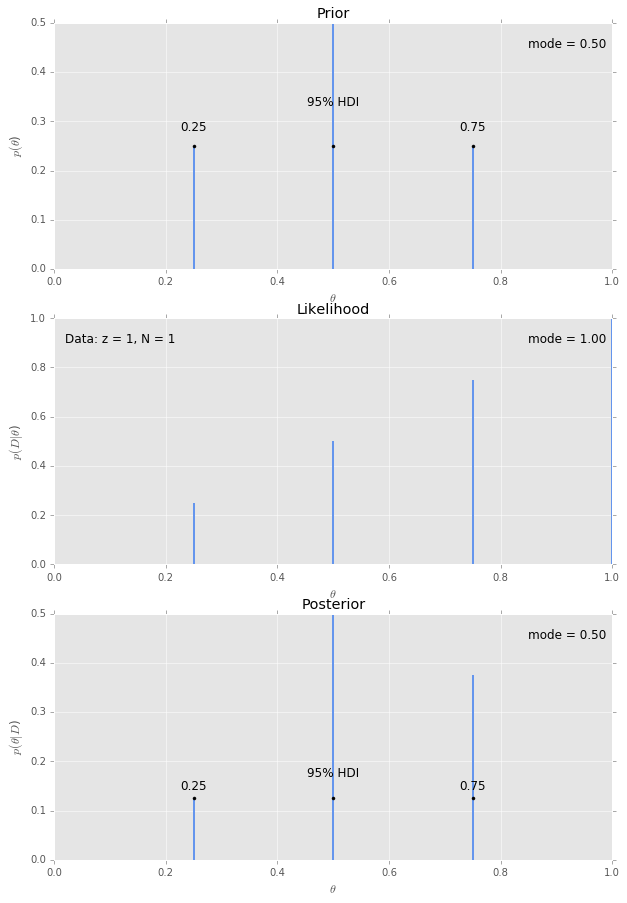

In [25]:
Theta = np.linspace(0, 1, num=5) # Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,0), np.repeat(1,1)))      # Single flip with 1 head

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

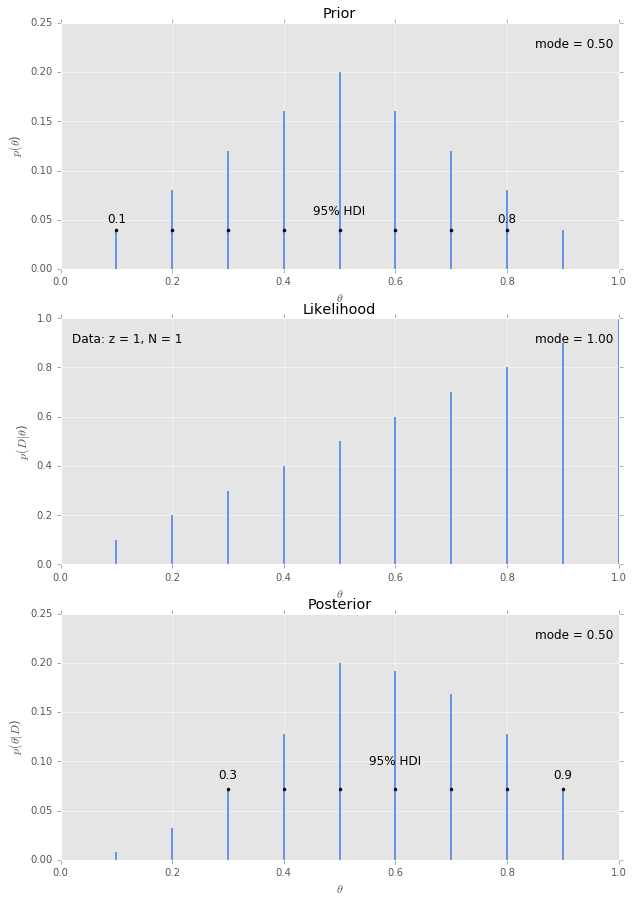

In [26]:
Theta = np.linspace(0, 1, num=11) # Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,0), np.repeat(1,1)))      # Single flip with 1 head

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

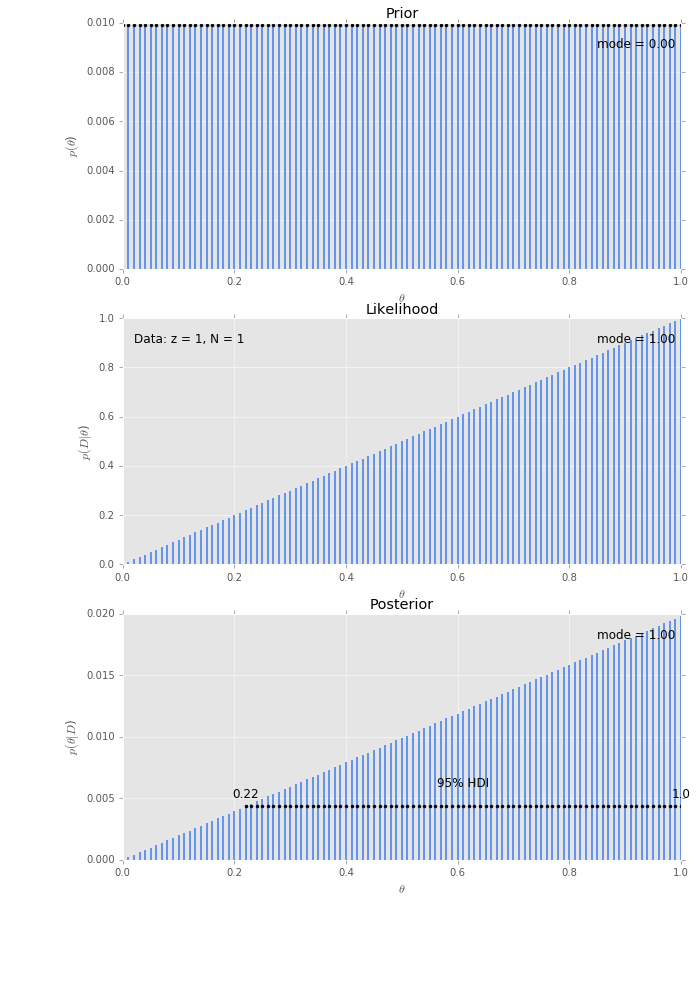

In [27]:
Theta = np.linspace(0, 1, num=101) # Fine teeth for Theta.
pTheta = np.full_like(Theta, 1) # Uniform (horizontal) shape for pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,0), np.repeat(1,1)))      # Single flip with 1 head

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

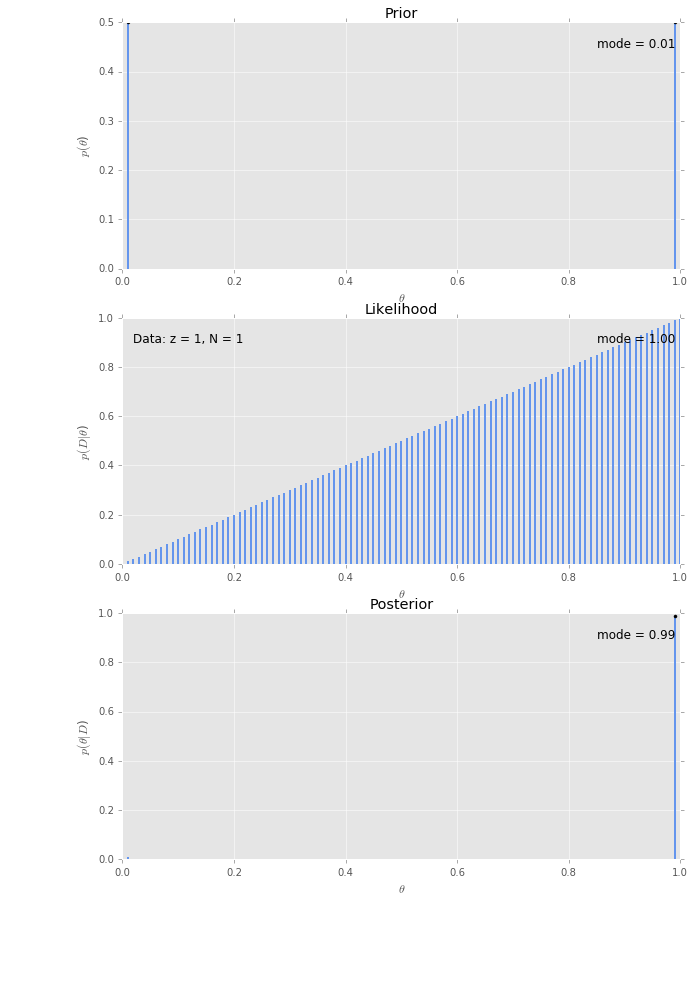

In [28]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.full_like(Theta, 0.0) # Only extremes are possible!
pTheta[1] = 1                      # Only extremes are possible!
pTheta[len(pTheta)-2] = 1       
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,0), np.repeat(1,1)))      # Single flip with 1 head

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

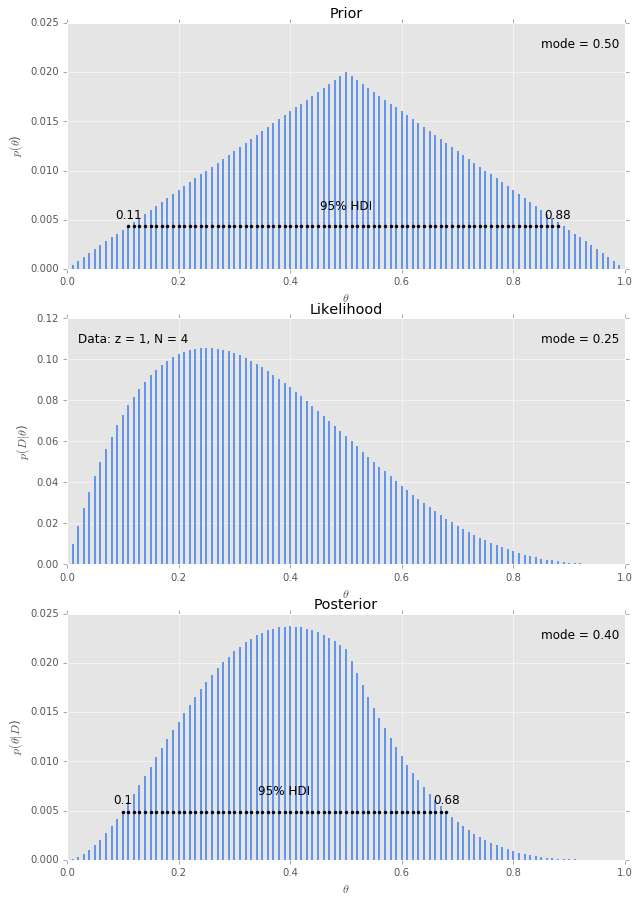

In [29]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,3), np.repeat(1,1))) # 25% heads, N=4

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

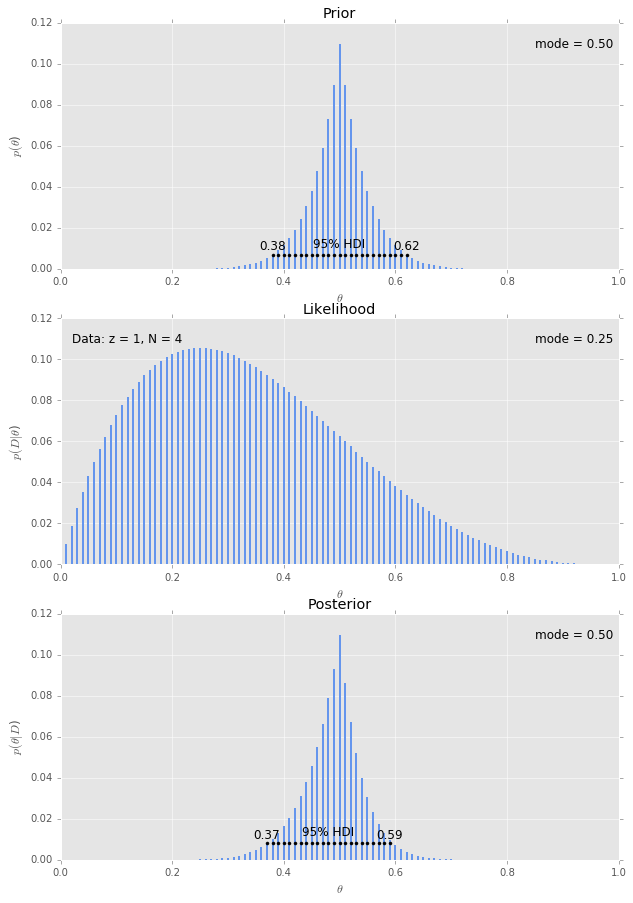

In [30]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta**10 # Sharpen pTheta !
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,3), np.repeat(1,1))) # 25% heads, N=4

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

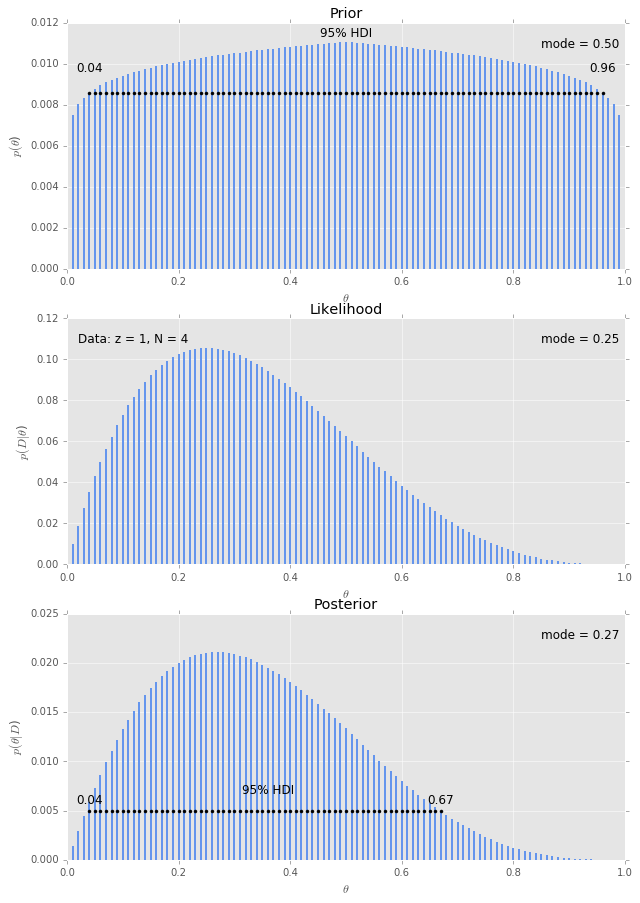

In [31]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta**0.1 # Flatten pTheta !
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,3), np.repeat(1,1))) # 25% heads, N=4

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

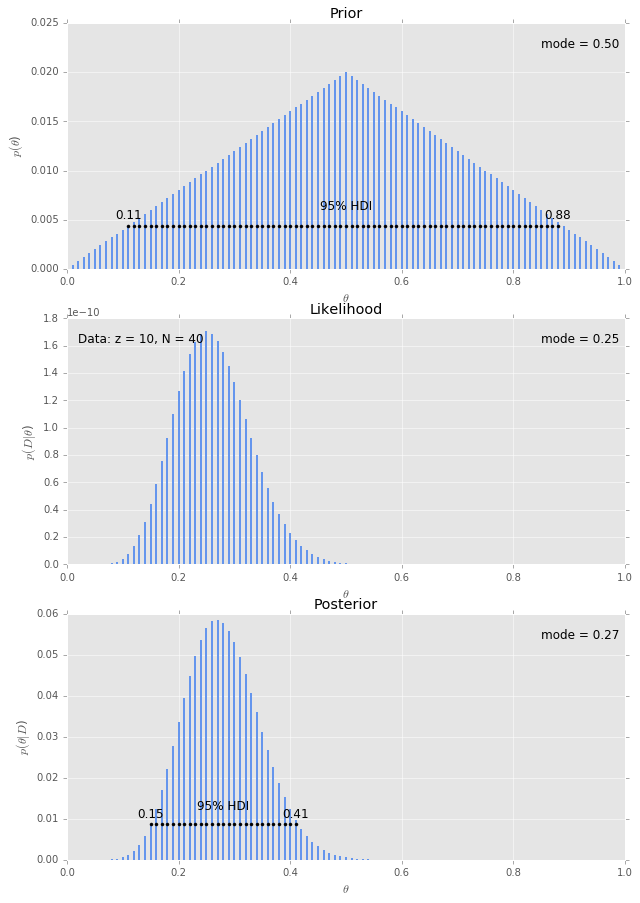

In [32]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,30), np.repeat(1,10))) # 25% heads, N=40

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

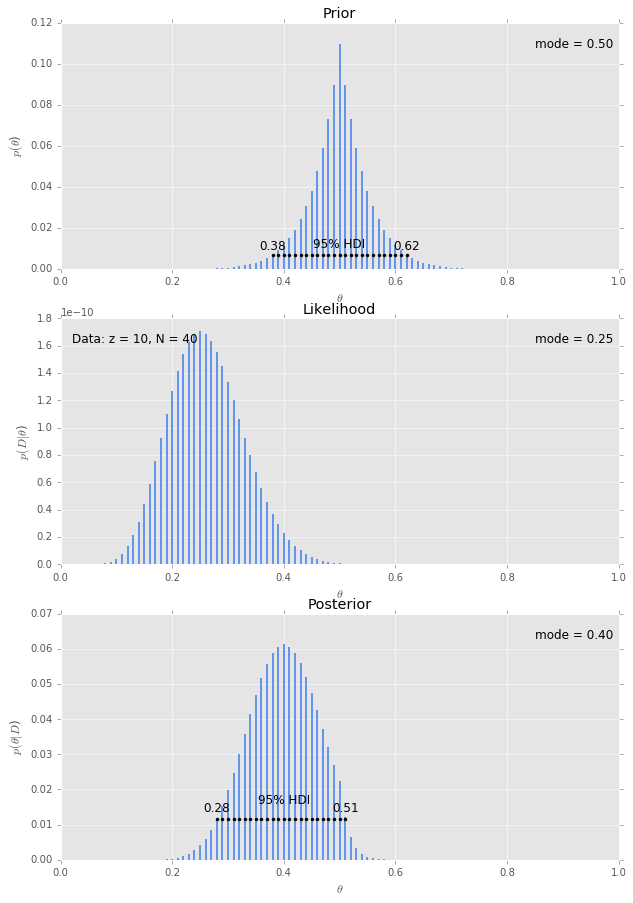

In [33]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta**10 # Sharpen pTheta !
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,30), np.repeat(1,10))) # 25% heads, N=40

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

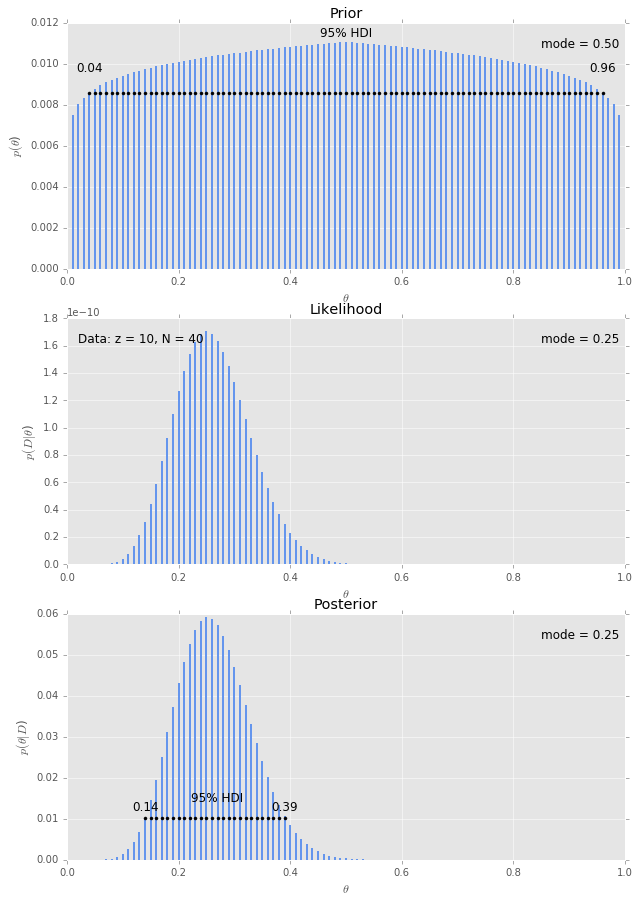

In [34]:
Theta = np.linspace(0, 1, num=101) # Fine Sparse teeth for Theta.
pTheta = np.minimum(Theta, 1-Theta) # Triangular shape for pTheta.
pTheta = pTheta**0.1 # Flatten pTheta !
pTheta = pTheta/sum(pTheta) # Make pTheta sum to 1.0
Data = np.concatenate((np.repeat(0,30), np.repeat(1,10))) # 25% heads, N=40

pDataGivenTheta = BernGrid(Theta, pTheta, Data)

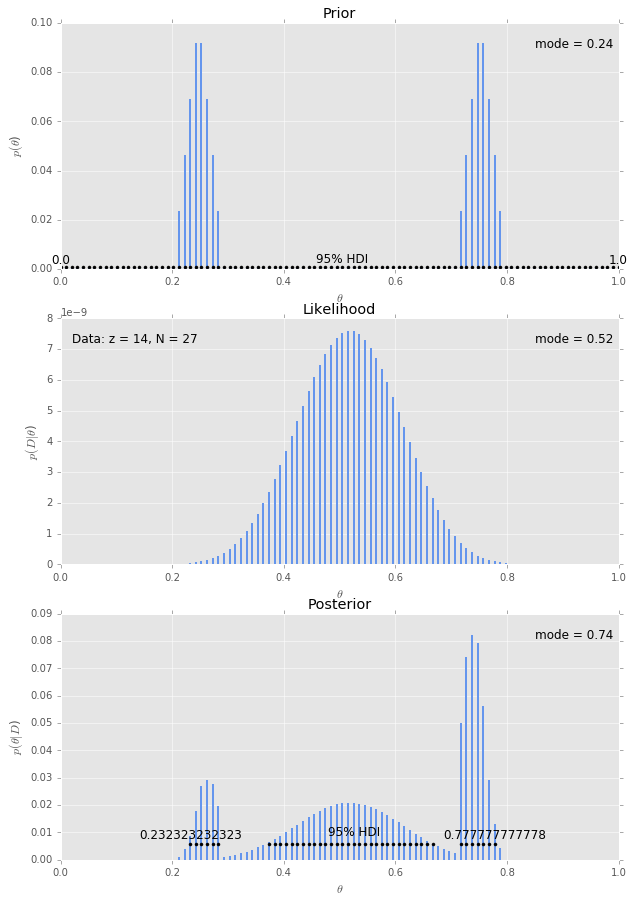

In [35]:
Theta = np.linspace(0, 1, num=100) # Fine Sparse teeth for Theta.

pTheta = np.concatenate((
        np.repeat(1,20),
        np.linspace(1,100, num=5),
        np.linspace(100,1, num=5),
        np.repeat(1,20),
        np.repeat(1,20),
        np.linspace(1,100, num=5),
        np.linspace(100,1, num=5),
        np.repeat(1,20)
    ))
pTheta = pTheta/sum(pTheta)      # Make pTheta sum to 1.0

Data = np.concatenate((np.repeat(0,13), np.repeat(1,14)))

pDataGivenTheta = BernGrid(Theta, pTheta, Data)